In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
arrest = pd.read_csv("raw/BPD_Arrests.csv")
arrest['IncidentOffense'] = arrest['IncidentOffense'].str.strip()
arrest2012 = pd.read_csv("raw/BPD_Arrests_2012.csv")

# type of offense

In [3]:
# no null value
print('null', arrest['IncidentOffense'].isnull().sum())

# distribution by type
incident = arrest['IncidentOffense'].value_counts().to_frame()
incident['Percentage'] = incident.IncidentOffense/incident.IncidentOffense.sum()
incident.head()

null 0


,IncidentOffense,Percentage
Unknown Offense,18067,0.664350
4ECOMMON ASSAULT,2019,0.074242
87NARCOTICS,1615,0.059386
4CAGG. ASSLT.- OTH.,569,0.020923
54ARMED PERSON,452,0.016621


In [4]:
top4_type = ['4ECOMMON ASSAULT', '87NARCOTICS', '4CAGG. ASSLT.- OTH.', '54ARMED PERSON',]

# age distribution

In [5]:
def hist_values(array, bins=None):
    if bins is None:
        count, division = np.histogram(array)
    else: 
        count, division = np.histogram(array, bins=bins)
    return [{'bin':'[%d,%d)' %(division[i], division[i+1]), 'count': count[i]} for i in range(len(count))]
        

In [6]:
hist = hist_values(arrest[~arrest.Age.isnull()].Age, bins=[0, 14, 18, 25, 35, 50, 100])
hist2012 = hist_values(arrest2012[~arrest2012.age.isnull()].age, bins=[0, 14, 18, 25, 35, 50, 100])

In [7]:
hist_df = pd.DataFrame(hist).rename(columns={'count':'since 2017'})
hist2012_df = pd.DataFrame(hist2012).rename(columns={'count':'in 2012'})

In [8]:
hist_df.merge(hist2012_df, on='bin')

,bin,since 2017,in 2012
0,"[0,14)",0,12
1,"[14,18)",246,164
2,"[18,25)",7257,14215
3,"[25,35)",9943,13914
4,"[35,50)",6660,13109
5,"[50,100)",3085,5421


# time series

In [9]:
min_date = '01/01/2017' 
max_date = '02/17/2018'
temporal_df = pd.DataFrame(index=pd.date_range(min_date, max_date))

In [10]:
temporal_df = temporal_df.join(arrest.groupby('ArrestDate').agg({'ArrestDate': 'count'}).rename(columns={'ArrestDate': 'ALL'}))

In [11]:
col = 'IncidentOffense'
for t in top4_type:
    temporal_df = temporal_df.join(
        arrest[arrest[col]==t].groupby('ArrestDate').agg({'ArrestDate': 'count'}).rename(columns={'ArrestDate':t}))

time series


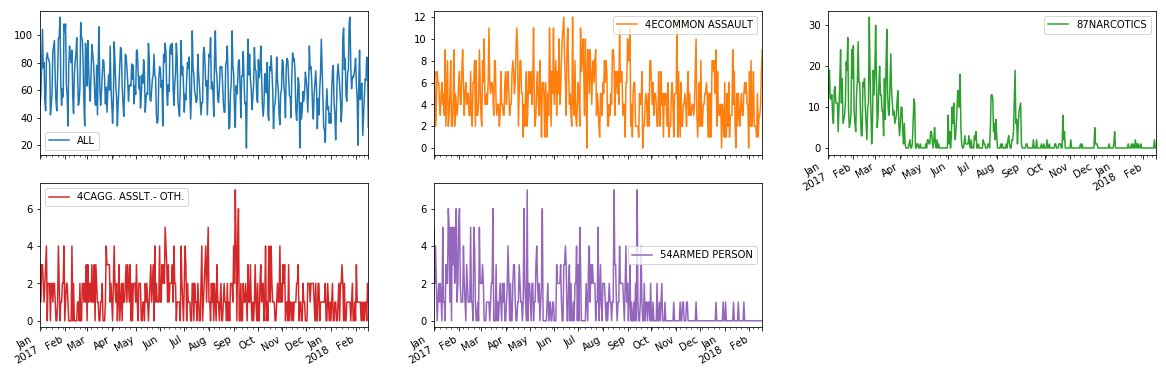

In [12]:
temporal_df.fillna(0).plot(subplots=True, layout=(3,3), figsize=(20,10))
print('time series')

# grid

In [13]:
from shapely.geometry import Point, box
import geopandas as gp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot

In [14]:

def grid_line(mini, maxi, ngrid=10):
    delta = (maxi - mini) / ngrid
    return [(mini + i * delta, mini + (i + 1) * delta) for i in range(ngrid)]


def grid_area(w, s, e, n, ngrid=10):
    """
    grid area into ngrid^2 grids
    :param w, s, e, n,: the w, s, e, n (min_lon, min_lat, max_lon, max_lat) of the bound box
    :param ngrid: divide area into ngrid^2 grids
    :return: list of grid represented by bound box with s,w,n,e
    """
    grid_lat = grid_line(s, n, ngrid)
    grid_lon = grid_line(w, e, ngrid)
    grids = []
    for i in range(ngrid):
        for j in range(ngrid):
            si, ni = grid_lat[i]
            wj, ej = grid_lon[j]
            grids.append((wj, si, ej, ni))
    return grids

In [15]:
cityline = gp.read_file('raw/Baltcity_Line/baltcity_line.shp')
cityline.to_crs(epsg=3559, inplace=True)

In [16]:
print('longitude, latitude')
cityline.to_crs(epsg=4326)

longitude, latitude


,AREA,BOUNDARY_,BOUNDARY_I,ID,LENGTH,PERIMETER,Shape_Leng,geometry
0,2.562713e+09,2.0,0.0,0.0,207126.513,207126.51563,207126.513062,LINESTRING (-76.7112936699702 39.3719570306727...


In [17]:
gpdf_arrest = arrest[['Longitude', 'Latitude', 'IncidentOffense']]
gpdf_arrest = gpdf_arrest[~gpdf_arrest.Longitude.isnull()]
gpdf_arrest['geometry'] = gpdf_arrest.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
gpdf_arrest = gp.GeoDataFrame(gpdf_arrest.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'})
gpdf_arrest.to_crs(cityline.crs, inplace=True)

In [20]:
line = cityline.geometry[0]
grids = grid_area(*line.bounds, ngrid=50)
wsen_poly = [box(*grid) for grid in grids]
wsen_poly = gp.GeoDataFrame(wsen_poly,columns=['geometry'], crs=cityline.crs)

distance between centroids of grids: 314.5389899998554


(-314.5389899999718, -388.1525280000933)

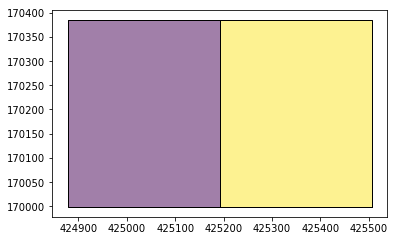

In [21]:
import math
[(a,b)] = wsen_poly.geometry[0].centroid.coords
[(c,d)] = wsen_poly.geometry[1].centroid.coords
print('distance between centroids of grids:', math.sqrt((a-c)**2+(b-d)**2))

wsen_poly[:2].plot()

a,b,c,d = wsen_poly.geometry[0].bounds
a-c, b-d

In [22]:
joined = gp.sjoin(gpdf_arrest, wsen_poly)

In [23]:
wsen_poly = wsen_poly.join(joined.groupby('index_right').agg({'IncidentOffense': 'count'}).rename(columns={'IncidentOffense':'ALL'}), how='inner')

In [24]:
col = 'IncidentOffense'
for t in top4_type:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({'IncidentOffense': 'count'}).rename(columns={'IncidentOffense':t}))

In [25]:
wsen_poly.fillna(0, inplace=True)

0 0
0 1
0 2
1 0
1 1


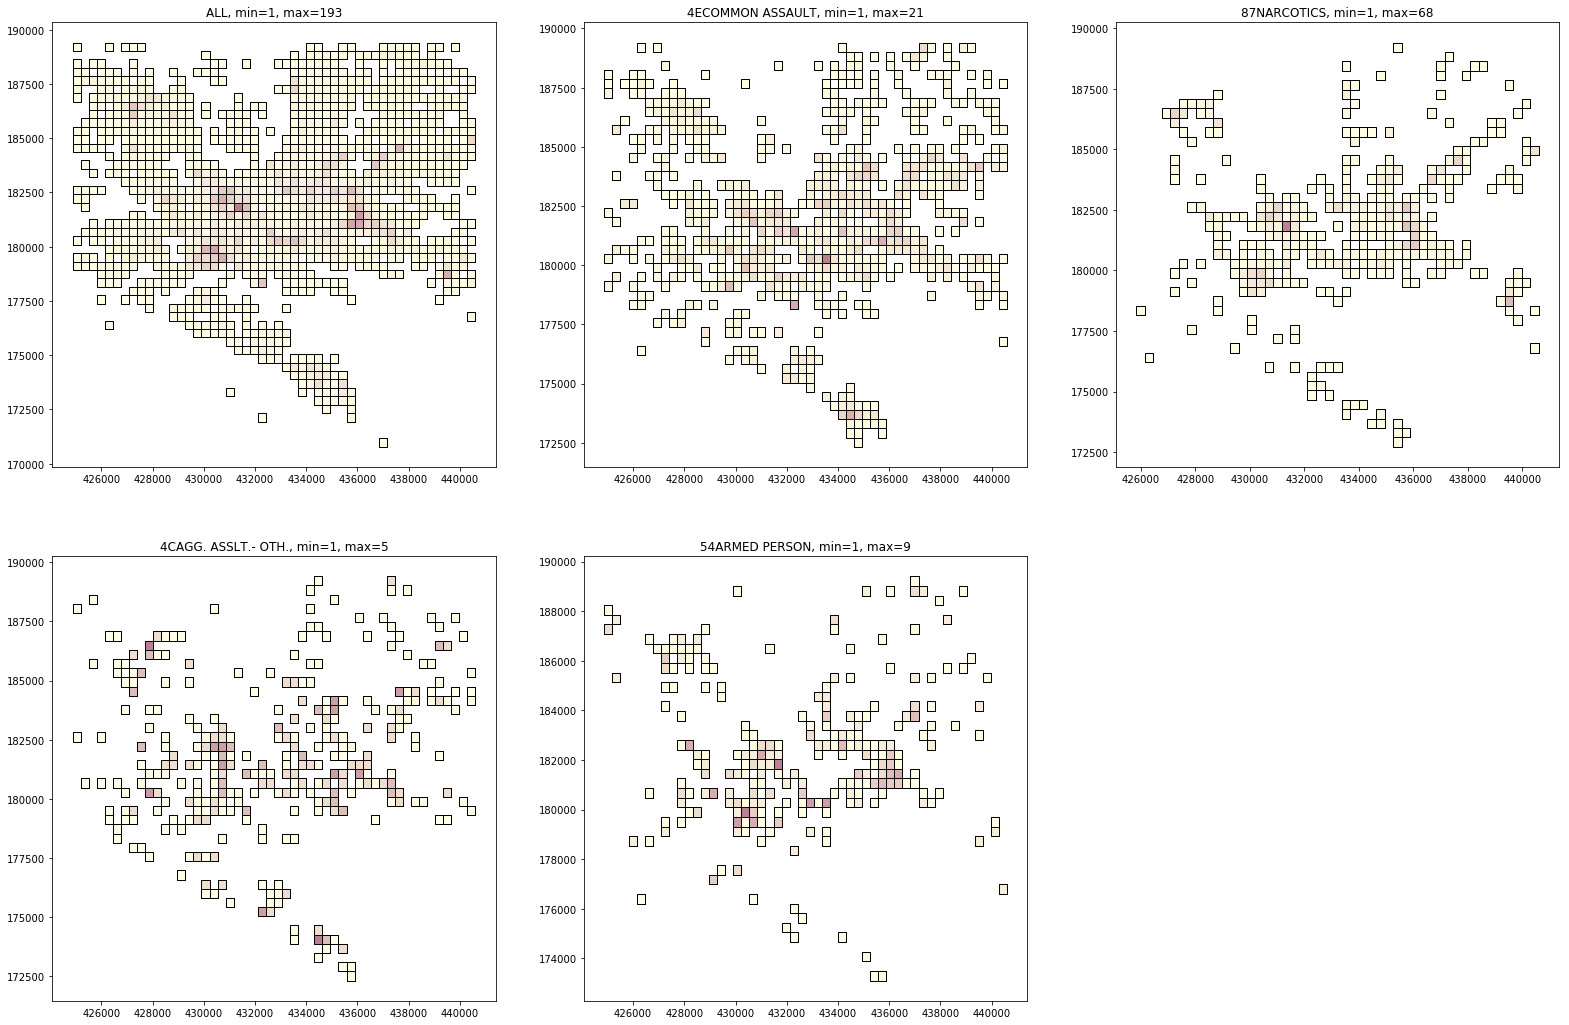

In [26]:

cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#ffffcc'), (1, '#800026')])
# fig, axes = pyplot.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(27, 18))
fig =pyplot.figure(figsize=(27,18))
for i, t in enumerate(['ALL'] + top4_type):
#     ax = axes[int(i/3)][i%3]
    print(int(i/3), i%3)
    ax = pyplot.subplot2grid((2,3), (int(i/3), i%3))
    mini, maxi = wsen_poly[wsen_poly[t]>0][t].min(), wsen_poly[t].max()
    ax.set_title('%s, min=%d, max=%d' % (t, mini, maxi))
    wsen_poly[wsen_poly[t]>0].plot(column=t, cmap=cmap, ax=ax, figsize=(9,9))
    

# spatial autocorrelation

In [27]:
import pysal

In [28]:
wsen_poly.index = range(wsen_poly.shape[0])

In [29]:
# There are different kinds of distance weights
# e.g. K nearest neighbours
ks = [1,2,3,4,5,6,7,8, 9, 10]
ws_knn = {k: pysal.weights.KNN.from_dataframe(wsen_poly[['geometry']], k=k) for k in ks}

# e.g. distanct band
# There are 2 kinds of distant band weight, binary or non-binary. I don't know the exact difference between them. 
# with correct CRS, the unit of the following dbs is meter
dbs = [315, 650, 980, 1300]
ws_db_notbinary = {db: pysal.weights.DistanceBand.from_dataframe(wsen_poly[['geometry']], threshold=db, binary=False, silent=True) for db in dbs}
ws_db_binary = {db: pysal.weights.DistanceBand.from_dataframe(wsen_poly[['geometry']], threshold=db, binary=True, silent=True) for db in dbs}

D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\sparse\data.py:103: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [30]:
# for KNN, every shape has k neighbors
# but for distance band, there are some islands which has no neighbors
# I choose 150 meter binary distance band weight in the cycling safety project considering the percentage of islands.
islands = [ws_db_binary[db].islands.__len__() for db in dbs]
pd.DataFrame(list(zip(dbs, islands)), columns=['band', 'num_islands']).set_index('band').T

band,315,650,980,1300
num_islands,72,10,5,4


In [31]:
def compute_moran_i(ws, param_list, x, pname):
    res = []

    for i, cname in enumerate(x):
        print('i=', i, cname)
            
        data = x[cname]
        for p in param_list:
            w = ws[p]
            mi = pysal.Moran(data, w, two_tailed=True, permutations=999)
            res.append({
                'column':cname, 
                pname:p,
                'I': mi.I, 
                'EI': mi.EI, 
                'p_norm': mi.p_norm * 2,
                'p_rand': mi.p_rand * 2,
                'z_norm': mi.z_norm,
                'z_rand': mi.z_rand,
            })
    print('done computing', pname)
    df = pd.DataFrame(res)
    return df[['column', pname, 'I', 'EI', 'p_norm', 'p_rand', 'z_norm', 'z_rand']]

In [32]:
# the function loop over each column of the features X. 
# It took quite a while for me to compute 200 features, maybe 1 hour or 2
# PySAL provides a function to compute moran I directly from a dataframe
# I don't know if that function would be faster

df_db_binary = compute_moran_i(ws_db_binary, dbs, wsen_poly.drop('geometry', axis=1), 'db_b')

i= 0 ALL
i= 1 4ECOMMON ASSAULT
i= 2 87NARCOTICS
i= 3 4CAGG. ASSLT.- OTH.
i= 4 54ARMED PERSON
done computing db_b


In [33]:
df_db_binary

,column,db_b,I,EI,p_norm,p_rand,z_norm,z_rand
0,ALL,315,0.534664,-0.000892,0.000000e+00,0.000000e+00,15.564091,15.936602
1,ALL,650,0.414680,-0.000892,0.000000e+00,0.000000e+00,25.533327,26.112644
2,ALL,980,0.330094,-0.000892,0.000000e+00,0.000000e+00,29.681328,30.301122
3,ALL,1300,0.252601,-0.000892,0.000000e+00,0.000000e+00,30.999540,31.556690
4,4ECOMMON ASSAULT,315,0.359566,-0.000892,0.000000e+00,0.000000e+00,10.475466,10.809556
5,4ECOMMON ASSAULT,650,0.247949,-0.000892,0.000000e+00,0.000000e+00,15.289144,15.757272
6,4ECOMMON ASSAULT,980,0.186070,-0.000892,0.000000e+00,0.000000e+00,16.765864,17.248197
7,4ECOMMON ASSAULT,1300,0.147787,-0.000892,0.000000e+00,0.000000e+00,18.181863,18.650798
8,87NARCOTICS,315,0.373668,-0.000892,0.000000e+00,0.000000e+00,10.885303,10.949358
9,87NARCOTICS,650,0.274638,-0.000892,0.000000e+00,0.000000e+00,16.928964,17.008585
